# 날씨 예측 모델 설계 (Day 8)


이 프로젝트는 시계열 날씨 데이터를 이용한 하여 미래 날씨를 예측하는 신경망 모델을 훈련합니다.

여기에서는 텐서플로 모델을 만들고 훈련할 수 있는 고수준 API인 tf.keras를 사용합니다.

신경망 모델로는 DNN, Convolutional Neural Network (CNN), Recurrent Neural Network (RNN)을 이용하여 시계열 예측을 진행하고 각각의 성능을 비교합니다.


In [ ]:
import os
import datetime

from IPython.display import clear_output

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from zipfile import ZipFile
import os
from keras.losses import mean_squared_error
from keras import backend as K


## 날씨 데이터셋 불러오기
본 실습은 <a href="https://www.bgc-jena.mpg.de" class="external">Max Planck Institute for Biogeochemistry</a>에서 수집 된 <a href="https://www.bgc-jena.mpg.de/wetter/" class="external">weather time series dataset</a> 을 사용합니다.


데이터 셋은 온도, 압력, 습도 등 14가지 feature으로 구성되며 10분 간격으로 구성되어 있습니다.

**위치**: 독일 제나에 있는 맥스플랑크 생물화학연구소 기상관

**기간**: 2009년 1월 10일 - 2016년 12월 31일

아래 표는 특징과 형식 및 간단한 설명을 보여줍니다.
[링크 텍스트]
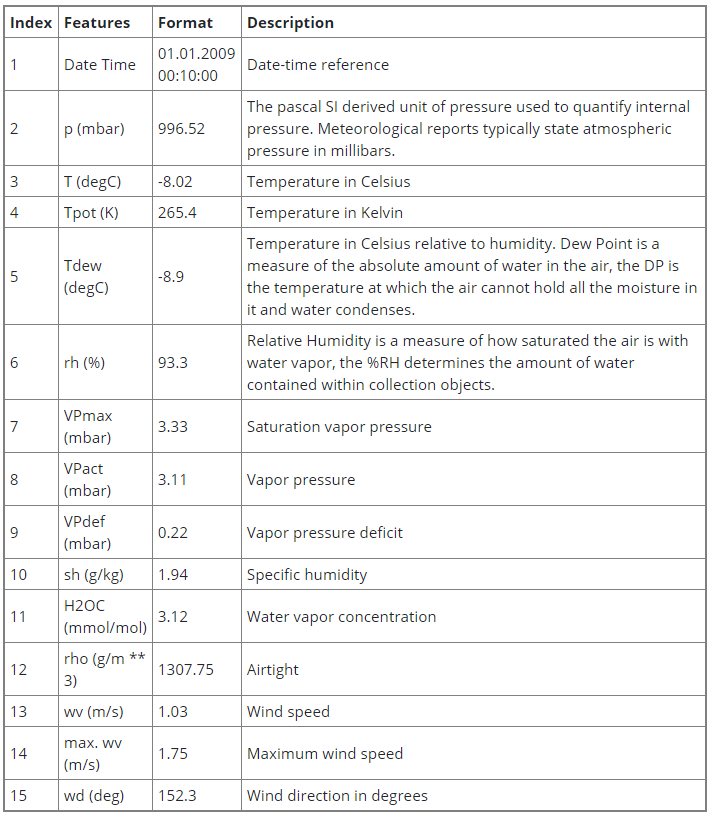


 weather time series dataset을 열어봅니다
 

## 데이터 탐색

데이터가 어떤 형태로 구성되어 있는지 보기 위해 정보를 확인합니다.

In [ ]:
df = pd.read_csv(csv_path)
df.info()

피쳐의 종류는 시간에 따라 총 14개가 있는 것을 확인하였습니다. 

데이터의 값을 보기 위해 앞의 샘플 5개를 확인해봅니다.

데이터는 2009년 1월 1일 부터 10분 간격으로 기록되어 있는 것을 확인할 수 있습니다. 

뒤의 샘플 5개도 확인해 봅니다

2016년 12월 30일 까지 기록되어 있음을 확인 할 수 있습니다.

특정 시간에 따른 **T(decC)과 p (mbar)**의 그래프를 확인해봅니다. 다른 feature에 대해서도 그래프 확인이 가능합니다.

## 데이터 전처리

데이터 셋의 statistics을 확인해 보기 위해 describe 함수를 활용해봅니다.

### 풍속 데이터 분석




데이터셋의 statistics을 보아 눈에 띄는 점 한 가지는 풍속 wv(m/s) 및 최대 풍속 wv(m/s)의 최소값입니다. 이는 -9999값으로 잘못된 갚으로 채워져 있다. 이를 각각의 평균 값으로 대체하거나 0으로 대체하는 방법이 있습니다.



### 데이터 사이의 상관도 분석

피쳐간의 상관도를 확인합니다.

### 학습 데이터 생성

데이터 분석단계에서 60분 이내에는 날씨 변화가 크지 않음을 확인 하였으므로 본 실습에서는 시간 당 하나의 샘플링을 진행합니다. 

특정 문제를 해결하기 위해 상관도가 높은 피쳐를 골라서 학습에 사용하는 것이 유리합니다.

In [ ]:

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]


우리는 훈련, 검증, 테스트 세트 구분을 위해 (70%, 20%, 10%) 의 비율로 분할합니다. 

데이터를 분할하기 전에 무작위로 섞지 않는다는 점에 유의해야합니다

### 정규화 단계

신경망을 훈련시키기 전에 피쳐의 크기를 조정하는 것은 매우 중요합니다. 


정규화는 가장 일반적인 방법이다. 평균을 빼고 각 피쳐의 표준 편차로 나누십시오.

**주의**: 평균 및 표준 편차는 모델들이 검증 및 테스트 데이터 셋 값에 접근하지 못하도록 훈련 데이터만을 사용해서 계산해야 합니다.


In [ ]:
# Live plot loss curve
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(np.sqrt(logs.get('loss')))
        self.val_losses.append(np.sqrt(logs.get('val_loss')))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="rmse")
        plt.plot(self.x, self.val_losses, label="val_rmse")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

Train the model and evaluate its performance:

You could train a `dense` model on a multiple-input-step window by adding a `layers.Flatten` as the first layer of the model: